    Time(h)  Modafinil_6h_50mg  LDX_6h_10mg  LDX_9h_5mg  Ritalin_13h_2mg  \
0       5.0           0.000000          NaN         NaN              NaN   
1       5.5           0.000000          NaN         NaN              NaN   
2       6.0           0.000000     0.000000         NaN              NaN   
3       6.5           0.000281     0.000128         NaN              NaN   
4       7.0           0.001415     0.000587         NaN              NaN   
5       7.5           0.003726     0.001433         NaN              NaN   
6       8.0           0.007468     0.002699         NaN              NaN   
7       8.5           0.012809     0.004410         NaN              NaN   
8       9.0           0.019806     0.006586    0.000000              NaN   
9       9.5           0.028388     0.009245    0.000064              NaN   
10     10.0           0.038347     0.012401    0.000294              NaN   
11     10.5           0.038082     0.016070    0.000717              NaN   
12     11.0 

/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_10896/548915637.py:28: RuntimeWarning: invalid value encountered in scalar power
  if ti < 6:    y[i] = (ti/6)**2.2
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_10896/548915637.py:28: RuntimeWarning: invalid value encountered in scalar power
  if ti < 6:    y[i] = (ti/6)**2.2
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_10896/548915637.py:15: RuntimeWarning: invalid value encountered in scalar power
  if ti <= 2:   y[i] = (ti/2)**2.2
/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_10896/548915637.py:15: RuntimeWarning: invalid value encountered in scalar power
  if ti <= 2:   y[i] = (ti/2)**2.2


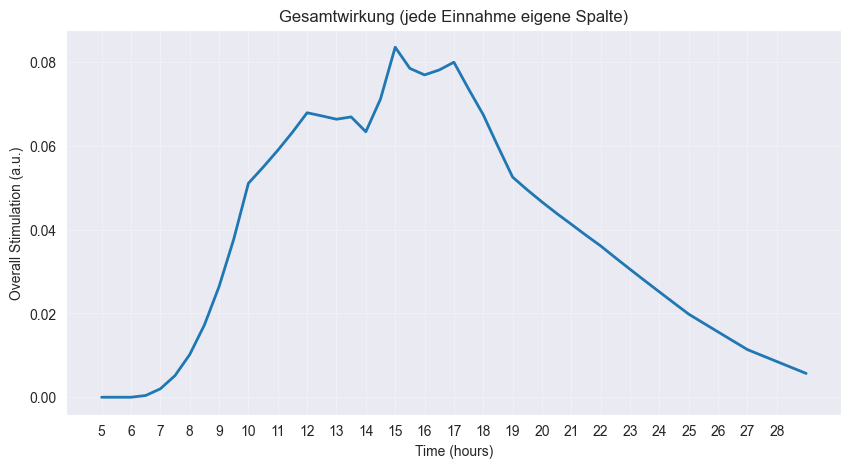

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Pharmakokinetik-Modelle -------------------------------------------------

def modafinil(t):
    rise = np.clip((t/4), 0, 1)**2.2
    decay = np.exp(-((t-4)/6)**2)
    return (rise * decay) * (t > 0)

def ritalin_ir(t):
    y = np.zeros_like(t)
    for i, ti in enumerate(t):
        if ti <= 2:   y[i] = (ti/2)**2.2
        elif ti <= 3: y[i] = 1 - 0.25*(ti-2)
        elif ti <= 4: y[i] = 0.75 - 0.35*(ti-3)
        elif ti <= 12:y[i] = 0.4 * (1 - (ti-4)/8)
        else:         y[i] = 0
    return y * (t > 0)

def ritalin_adult(t):
    return (np.exp(-((t-2)/1.5)**2) + 0.6*np.exp(-((t-6)/2)**2)) * (t > 0)

def ldx(t):
    y = np.zeros_like(t)
    for i, ti in enumerate(t):
        if ti < 6:    y[i] = (ti/6)**2.2
        elif ti < 8:  y[i] = 1
        elif ti < 12: y[i] = 0.75 + (0.66 - 0.75)*((ti-8)/4)
        elif ti < 16: y[i] = 0.66 + (0.5  - 0.66)*((ti-12)/4)
        elif ti < 24: y[i] = 0.5 * (1 - (ti-16)/8)
        else:         y[i] = 0
    return y * (t > 0)

models = {
    'Modafinil': modafinil,
    'RitalinAdult': ritalin_adult,
    'Ritalin': ritalin_ir,
    'LDX': ldx
}

# --- AUC-Normierung ----------------------------------------------------------

t_ref = np.linspace(0, 24, 2000)
for k, f in models.items():
    auc = np.trapz(f(t_ref), t_ref)
    models[k] = (lambda tt, f=f, auc=auc: f(tt)/auc)

# --- Einnahmeplan (jede Zeile wird eigene Spalte) ----------------------------

schedule = pd.DataFrame([
    {'time':6,  'drug':'Modafinil', 'dose':50},
    {'time':6,  'drug':'LDX', 'dose':10},
    {'time':9,  'drug':'LDX', 'dose':5},
    {'time':13,  'drug':'Ritalin', 'dose':2},
    {'time':15,  'drug':'Ritalin', 'dose':2},
])

# Äquivalente Dosis-Verhältnisse (gleiche AUC)
eq = {'Ritalin':20, 'RitalinAdult':20, 'LDX':30, 'Modafinil':200}
scale = {k:1/v for k,v in eq.items()}

# --- Zeitachse (0.5h-Schritte) ----------------------------------------------

times = np.arange(5, 29.01, 0.5)
df = pd.DataFrame({'Time(h)': times})

# --- Für jede Einnahme eine eigene Spalte erzeugen ---------------------------

for i, r in schedule.iterrows():
    func = models[r.drug]
    dose_factor = r.dose * scale.get(r.drug, 1)
    col_name = f"{r.drug}_{r.time}h_{r.dose}mg"
    df[col_name] = func(times - r.time) * dose_factor

# --- Gesamtspalte ------------------------------------------------------------

dose_cols = [c for c in df.columns if c != 'Time(h)']
df['Overall'] = df[dose_cols].sum(axis=1)

# --- Ausgabe -----------------------------------------------------------------

print(df.head(15))  # Beispieltabellenkopf

plt.figure(figsize=(10,5))
plt.plot(df['Time(h)'], df['Overall'], linewidth=2)
plt.xlabel('Time (hours)')
plt.ylabel('Overall Stimulation (a.u.)')
plt.title('Gesamtwirkung (jede Einnahme eigene Spalte)')
plt.xticks(np.arange(5, 29, 1))
plt.grid(True, alpha=0.3)
plt.show()




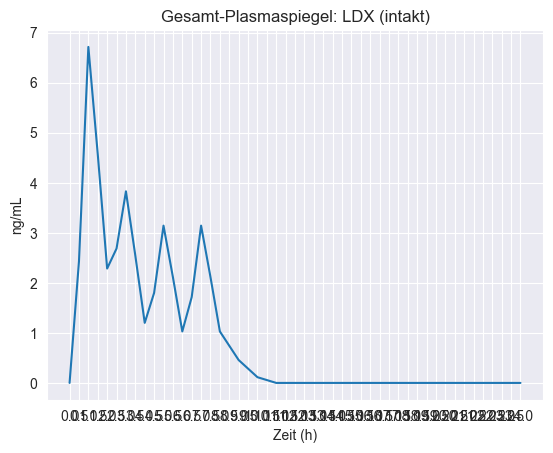

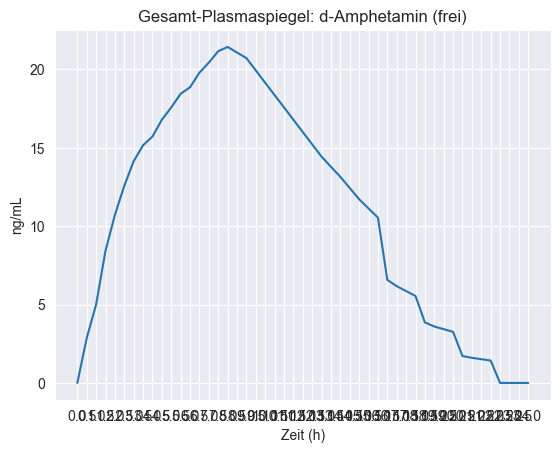

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parameter ----------------
duration_h = 24  # Simulationsdauer (0..duration_h in 0.5-h-Schritten)
# Dosen: {volle_Stunde: mg}
doses = {0: 10, 2: 4, 4: 4, 6:4}  # Beispiel – nach Bedarf anpassen

# ---------- Basis-Profile (70 mg) in vollen Stunden ----------
# LDX (intakt) – bekannte Frühwerte + volle Stunden bis 16 h
ldx_full = {0: 0, 1: 47, 2: 16, 3: 8, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0,
            9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}
# d-Amphetamin (frei) – volle Stunden bis 16 h
dex_full = {0: 0, 1: 35, 2: 75, 3: 85, 4: 80, 5: 75, 6: 70, 7: 65, 8: 60,
            9: 55, 10: 50, 11: 45, 12: 40, 13: 35, 14: 32, 15: 28, 16: 25}

# zusätzliche bekannte Früh-Halbstunden:
ldx_known_half = {0.5: 17, 1.5: 32}
dex_known_half = {0.5: 20, 1.5: 59}

# ---------- 30-minütige Profile erzeugen ----------
def build_half_hour_profile(full_hours: dict, known_halfs: dict):
    # Start mit vollen Stunden
    profile = {float(k): float(v) for k, v in full_hours.items()}
    # Halb-Stunden mit bekannten Werten
    profile.update({float(k): float(v) for k, v in known_halfs.items()})
    # Restliche Halb-Stunden als Mittel der Nachbarstunden
    max_h = max(full_hours.keys())
    for n in range(0, int(max_h)):
        t_half = n + 0.5
        if t_half in profile:
            continue
        if n in full_hours and (n+1) in full_hours:
            profile[t_half] = 0.5 * (full_hours[n] + full_hours[n+1])
    # nur 0..16 h nach Gabe
    return {t: profile[t] for t in sorted(profile) if 0 <= t <= 16}

ldx_profile_70 = build_half_hour_profile(ldx_full, ldx_known_half)
dex_profile_70 = build_half_hour_profile(dex_full, dex_known_half)

# ---------- Zeitleiste & Ergebnis-DF ----------
times = np.arange(0, duration_h + 0.0001, 0.5)  # 0.5-h Raster
df = pd.DataFrame(index=times)

df["Total_LDX"] = 0.0
df["Total_Dex"] = 0.0

# ---------- Beiträge jeder Dosis addieren ----------
for t_dose, mg in sorted(doses.items()):
    assert float(t_dose).is_integer(), "Dosen nur zu vollen Stunden!"
    scale = mg / 70.0
    col_ldx = f"LDX@{t_dose}h_{mg}mg"
    col_dex = f"Dex@{t_dose}h_{mg}mg"
    df[col_ldx] = 0.0
    df[col_dex] = 0.0

    for h_rel, c in ldx_profile_70.items():
        t_abs = t_dose + h_rel
        if t_abs > duration_h:
            break
        df.at[round(t_abs, 1), col_ldx] += scale * c

    for h_rel, c in dex_profile_70.items():
        t_abs = t_dose + h_rel
        if t_abs > duration_h:
            break
        df.at[round(t_abs, 1), col_dex] += scale * c

    df["Total_LDX"] += df[col_ldx]
    df["Total_Dex"] += df[col_dex]

# ---------- Plot: Summenspalten ----------
plt.figure()
plt.plot(df.index, df["Total_LDX"])
plt.title("Gesamt-Plasmaspiegel: LDX (intakt)")
plt.xlabel("Zeit (h)")
plt.ylabel("ng/mL")
plt.xticks(np.arange(0, duration_h + 0.5, 0.5))
plt.grid(True)

plt.figure()
plt.plot(df.index, df["Total_Dex"])
plt.title("Gesamt-Plasmaspiegel: d-Amphetamin (frei)")
plt.xlabel("Zeit (h)")
plt.ylabel("ng/mL")
plt.xticks(np.arange(0, duration_h + 0.5, 0.5))
plt.grid(True)

plt.show()

# Optional: df anzeigen
# df
